In [12]:
import sys
import os
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [13]:
sys.path.insert(0, '../')
from scale_rl.common.wandb_utils import *

#### Collect Results

In [14]:
entity = 'draftrec'
project_name = 'HyperSimba_2412'
run_exp_names_to_analysis_exp_names = {
    #'hyper_sac_invd_invd_targetema': 'hypersimba',
    #'a_no_input_norm': 'a_no_input_norm',
    #'b_no_shift': 'b_no_shift',
    #'c_shift_1': 'c_shift_1',
    #'d_resize_proj': 'd_resize_proj',
    #'e_mse_loss': 'e_mse_loss',
    #'f_no_rew_normalize': 'f_no_rew_normalize',
    #'g_no_rew_bound': 'g_no_rew_bound',
    #'h_hard_target_copy': 'h_hard_target_copy',
    #'i_no_lr_decay': 'i_no_lr_decay',
    #'hyper_sac_1_invd_targetema': 'j_scaler_init_1',
    #'hyper_sac_invd_1_targetema': 'k_scaler_scale_1',
    'l_alpha_init_05': 'l_alpha_init_05',
    'm_alpha_scale_1': 'm_alpha_scale_1',
}
run_exp_names = list(run_exp_names_to_analysis_exp_names.keys())
metrics = ['avg_return', 'avg_success']

In [16]:
runs = collect_runs(entity=entity, project_name=project_name) 
filtered_runs = filter_runs(runs, exp_names = run_exp_names)
wandb_df = convert_runs_to_dataframe(
    runs = filtered_runs, 
    run_exp_name_to_analysis_exp_name=run_exp_names_to_analysis_exp_names
)
wandb_df = wandb_df[wandb_df.apply(lambda row: 'finished' in str(row['run']), axis=1)]
run_eval_df = convert_wandb_df_to_eval_df(wandb_df, metrics)
run_eval_df

100%|██████████| 442/442 [03:27<00:00,  2.13it/s]


,exp_name,env_name,seed,metric,env_step,value
0,m_alpha_scale_1,h1-sit_hard-v0,3000,avg_return,0.0,6.050815
1,m_alpha_scale_1,h1-sit_hard-v0,3000,avg_return,100000.0,155.829546
2,m_alpha_scale_1,h1-sit_hard-v0,3000,avg_return,200000.0,327.709867
3,m_alpha_scale_1,h1-sit_hard-v0,3000,avg_return,300000.0,399.681769
4,m_alpha_scale_1,h1-sit_hard-v0,3000,avg_return,400000.0,402.900550
...,...,...,...,...,...,...
10519,m_alpha_scale_1,HalfCheetah-v4,0,avg_success,800000.0,0.000000
10520,m_alpha_scale_1,HalfCheetah-v4,0,avg_success,850000.0,0.000000
10521,m_alpha_scale_1,HalfCheetah-v4,0,avg_success,900000.0,0.000000
10522,m_alpha_scale_1,HalfCheetah-v4,0,avg_success,950000.0,0.000000


In [17]:
save_eval_df(run_eval_df, directory_path='../results/hypersimba/design_study')

In [44]:
eval_df = read_and_concatenate_eval_df(directory_path='../results/hypersimba/design_study')
print(eval_df['exp_name'].unique())
eval_df

['k_scaler_scale_1' 'e_mse_loss' 'g_no_rew_bound' 'j_scaler_init_1'
 'f_no_rew_normalize' 'i_no_lr_decay' 'b_no_shift' 'h_hard_target_copy'
 'c_shift_1' 'a_no_input_norm' 'd_resize_proj']


,exp_name,env_name,seed,metric,env_step,value
0,k_scaler_scale_1,h1-pole-v0,9000,avg_return,0.0,35.859411
1,k_scaler_scale_1,h1-pole-v0,9000,avg_return,100000.0,142.686500
2,k_scaler_scale_1,h1-pole-v0,9000,avg_return,200000.0,547.310449
3,k_scaler_scale_1,h1-pole-v0,9000,avg_return,300000.0,533.528960
4,k_scaler_scale_1,h1-pole-v0,9000,avg_return,400000.0,674.806596
...,...,...,...,...,...,...
74315,d_resize_proj,HalfCheetah-v4,0,avg_success,800000.0,0.000000
74316,d_resize_proj,HalfCheetah-v4,0,avg_success,850000.0,0.000000
74317,d_resize_proj,HalfCheetah-v4,0,avg_success,900000.0,0.000000
74318,d_resize_proj,HalfCheetah-v4,0,avg_success,950000.0,0.000000


#### Visualize Results

In [45]:
from rliable import library as rly
from rliable import metrics as rly_metrics
from rliable import plot_utils as rly_plot_utils

aggregate_func = lambda x: np.array([
  rly_metrics.aggregate_iqm(x),
  rly_metrics.aggregate_median(x),
  rly_metrics.aggregate_mean(x),
  rly_metrics.aggregate_optimality_gap(x)])

In [46]:
from scale_rl.envs.mujoco import MUJOCO_ALL, MUJOCO_RANDOM_SCORE, MUJOCO_TD3_SCORE
from scale_rl.envs.dmc import DMC_EASY_MEDIUM, DMC_HARD
from scale_rl.envs.humanoid_bench import HB_LOCOMOTION_NOHAND, HB_RANDOM_SCORE, HB_SUCCESS_SCORE
from scale_rl.envs.myosuite import MYOSUITE_TASKS

In [47]:
def replace_hypen_to_underbar(env_name_list):
    for idx in range(len(env_name_list)):
        env_name_list[idx] = env_name_list[idx].replace('-', '_')
    return env_name_list

def replace_hyphen_in_dict_keys(old_dict):
    new_dict = {}
    for k, v in old_dict.items():
        new_key = k.replace('-', '_')  # <--- direct string replace
        new_dict[new_key] = v
    return new_dict

MUJOCO_ALL = replace_hypen_to_underbar(MUJOCO_ALL)
DMC_EM = replace_hypen_to_underbar(DMC_EASY_MEDIUM)
DMC_HARD = replace_hypen_to_underbar(DMC_HARD)
MYOSUITE_TASKS = replace_hypen_to_underbar(MYOSUITE_TASKS)
HB_LOCOMOTION_NOHAND = replace_hypen_to_underbar(HB_LOCOMOTION_NOHAND)

MUJOCO_RANDOM_SCORE = replace_hyphen_in_dict_keys(MUJOCO_RANDOM_SCORE)
MUJOCO_TD3_SCORE = replace_hyphen_in_dict_keys(MUJOCO_TD3_SCORE)
HB_RANDOM_SCORE = replace_hyphen_in_dict_keys(HB_RANDOM_SCORE)
HB_SUCCESS_SCORE = replace_hyphen_in_dict_keys(HB_SUCCESS_SCORE)

eval_df['env_name'] = eval_df['env_name'].str.replace('-', '_')
eval_df

,exp_name,env_name,seed,metric,env_step,value
0,k_scaler_scale_1,h1_pole_v0,9000,avg_return,0.0,35.859411
1,k_scaler_scale_1,h1_pole_v0,9000,avg_return,100000.0,142.686500
2,k_scaler_scale_1,h1_pole_v0,9000,avg_return,200000.0,547.310449
3,k_scaler_scale_1,h1_pole_v0,9000,avg_return,300000.0,533.528960
4,k_scaler_scale_1,h1_pole_v0,9000,avg_return,400000.0,674.806596
...,...,...,...,...,...,...
74315,d_resize_proj,HalfCheetah_v4,0,avg_success,800000.0,0.000000
74316,d_resize_proj,HalfCheetah_v4,0,avg_success,850000.0,0.000000
74317,d_resize_proj,HalfCheetah_v4,0,avg_success,900000.0,0.000000
74318,d_resize_proj,HalfCheetah_v4,0,avg_success,950000.0,0.000000


In [48]:
cur_exp_names = [
    #'sac_simba',
]
cur_exp_names = eval_df['exp_name'].unique()
cur_exp_names

array(['k_scaler_scale_1', 'e_mse_loss', 'g_no_rew_bound',
       'j_scaler_init_1', 'f_no_rew_normalize', 'i_no_lr_decay',
       'b_no_shift', 'h_hard_target_copy', 'c_shift_1', 'a_no_input_norm',
       'd_resize_proj'], dtype=object)

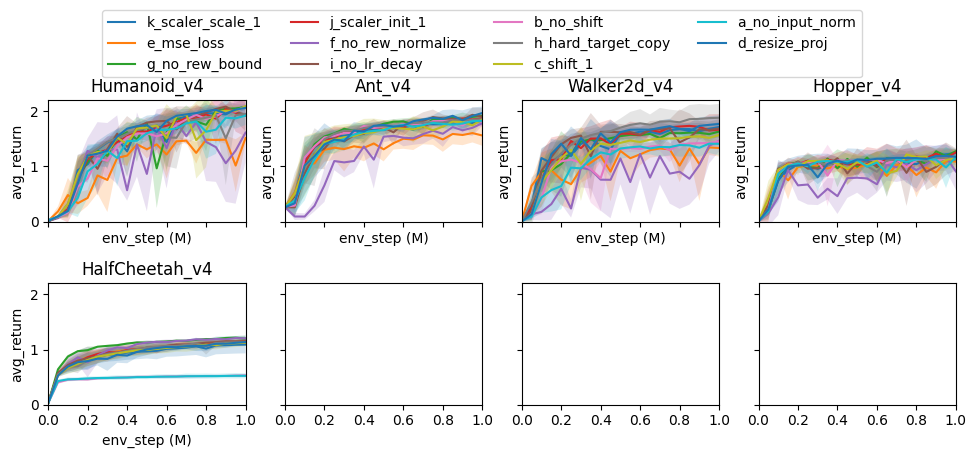

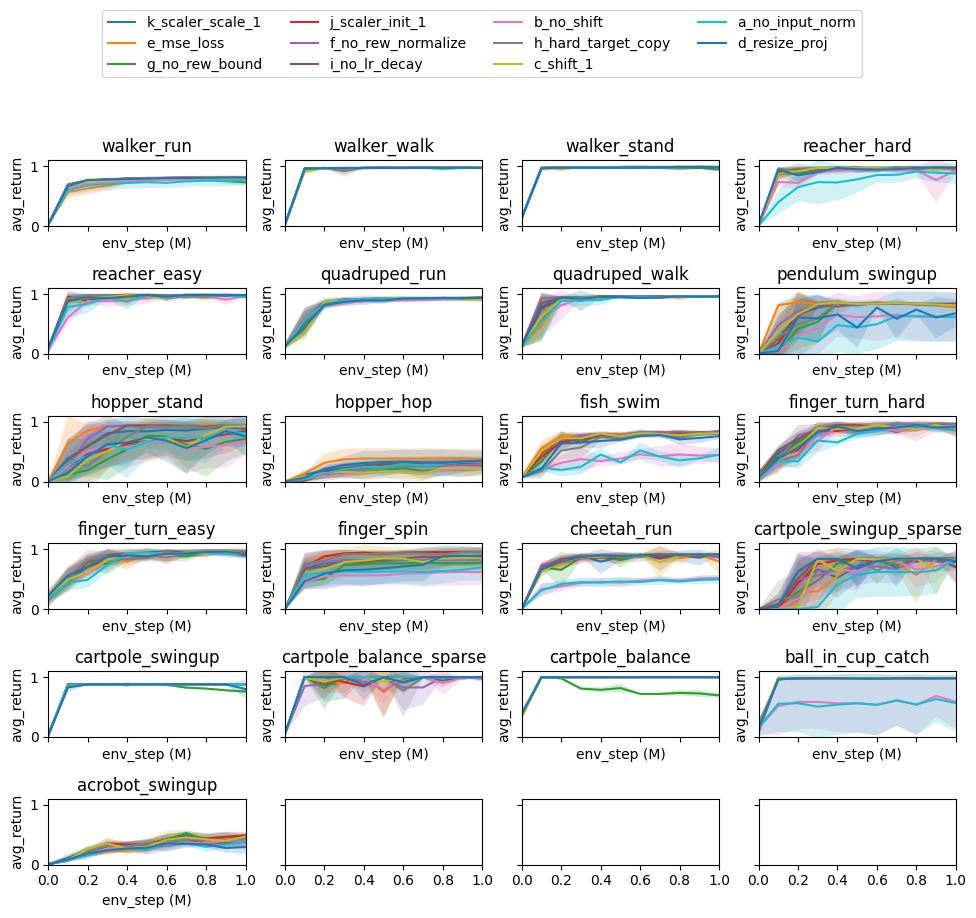

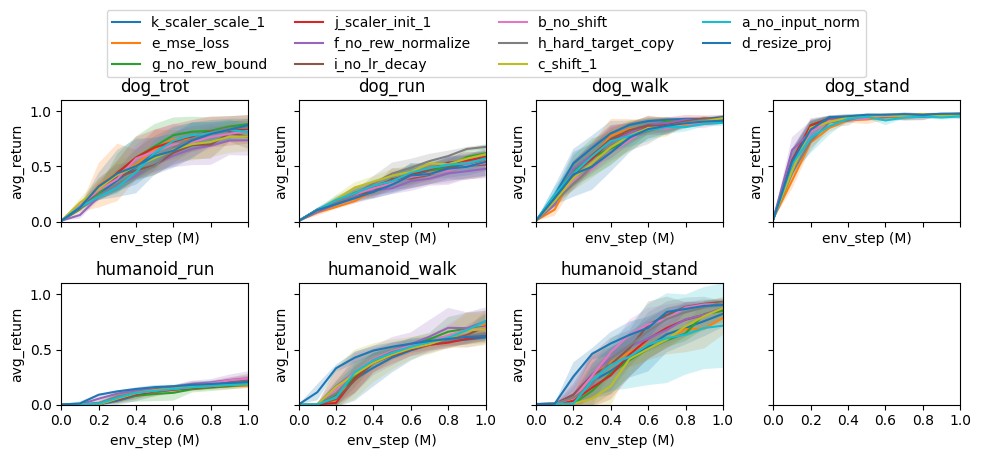

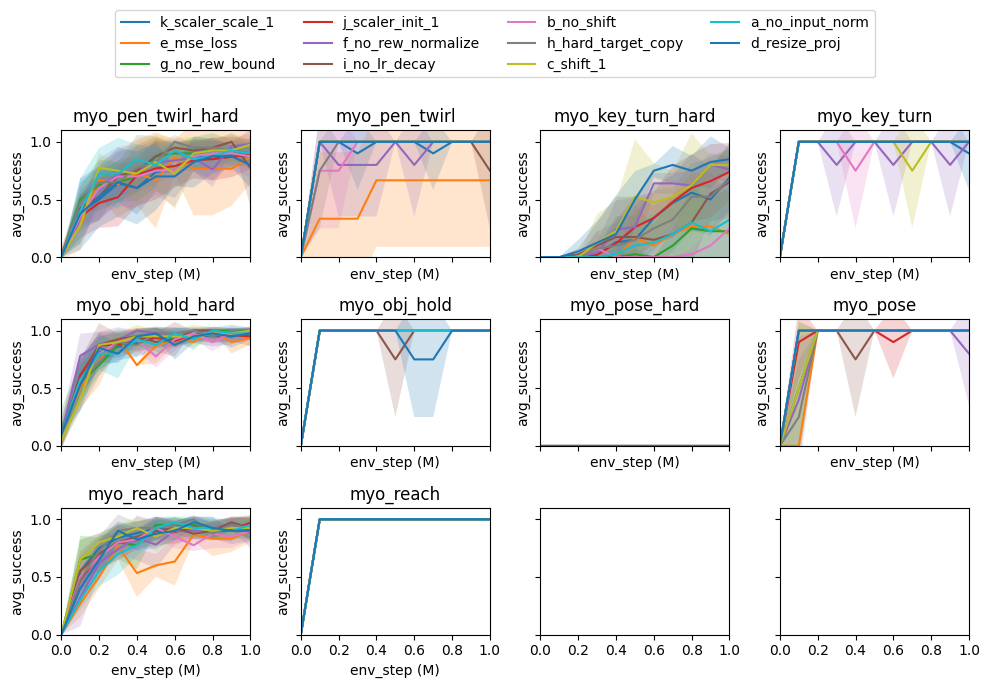

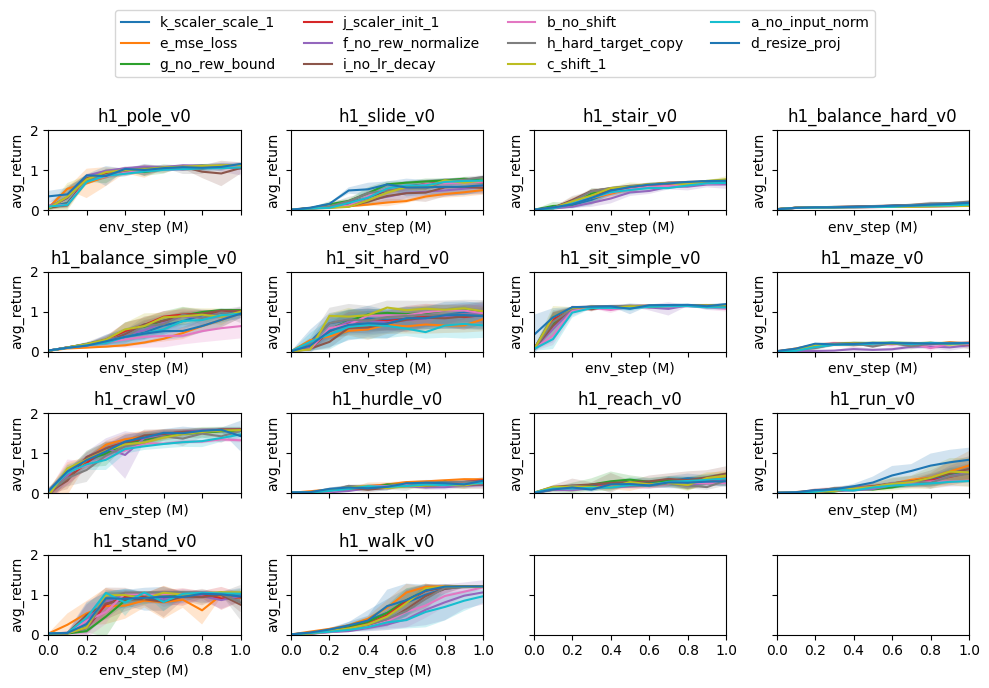

In [49]:
all_metric_mats = defaultdict(list)

for env_type in ["MUJOCO", "DMC_EM", "DMC_HARD", "MYOSUITE", "HB"]:
    if env_type == "MUJOCO":
        env_list = MUJOCO_ALL
        env_step = 1e6
        metric_type = "avg_return"
        plot_height = 4
        y_lim_max = 2.2

    elif env_type == "DMC_EM":
        env_list = DMC_EM
        env_step = 1e6
        metric_type = "avg_return"
        plot_height = 8
        y_lim_max = 1.1

    elif env_type == "DMC_HARD":
        env_list = DMC_HARD
        env_step = 1e6
        metric_type = "avg_return"
        plot_height = 4
        y_lim_max = 1.1

    elif env_type == "MYOSUITE":
        env_list = MYOSUITE_TASKS
        env_step = 1e6
        metric_type = "avg_success"
        plot_height = 6
        y_lim_max = 1.1

    elif env_type == "HB":
        env_list = HB_LOCOMOTION_NOHAND
        env_step = 1e6
        metric_type = "avg_return"
        plot_height = 6
        y_lim_max = 2.0

    # Filter eval_df for current environment set and experiments
    _eval_df = eval_df[eval_df["env_name"].isin(env_list)]
    _eval_df = _eval_df[_eval_df["exp_name"].isin(cur_exp_names)]

    # Additional environment-specific normalization, etc.
    if env_type == "MUJOCO":
        _eval_df = normalize_score_with_random_and_base_score(
            _eval_df,
            MUJOCO_RANDOM_SCORE,
            MUJOCO_TD3_SCORE,
        )
    elif env_type in ["DMC_EM", "DMC_HARD"]:
        _eval_df.loc[:, "value"] /= 1000.0
    elif env_type == "HB":
        _eval_df = normalize_score_with_random_and_base_score(
            _eval_df,
            HB_RANDOM_SCORE,
            HB_SUCCESS_SCORE,
        )

    # (Optional) plot metric history for each environment in this env_type
    plot_metric_history_per_env(
        _eval_df,
        num_plots_per_row=4,
        metric=metric_type,
        x_lim_max=env_step,
        y_lim_max=y_lim_max,
        plot_width=10,
        plot_height=plot_height,
        y_label=metric_type,
    )

    # Generate metric matrix dictionary for this env_type
    _metric_matrix_dict = generate_metric_matrix_dict(
        _eval_df, env_step=env_step, metric_type=metric_type
    )

    # Collect these matrices into all_metric_mats
    for exp_name, mat in _metric_matrix_dict.items():
        all_metric_mats[exp_name].append(mat)


In [50]:
metric_matrix_dict = {}
for exp_name, mats_list in all_metric_mats.items():
    # Find the minimum number of seeds among all matrices in mats_list
    min_num_seeds = min(mat.shape[1] for mat in mats_list)
    
    # Slice each matrix to keep only the first min_num_seeds columns
    mats_sliced = [mat[:, :min_num_seeds] for mat in mats_list]
    
    # Concatenate vertically
    # Resulting shape: [sum_of_envs_across_env_types, min_num_seeds]
    metric_matrix_dict[exp_name] = np.concatenate(mats_sliced, axis=0)

aggregate_scores = {}
aggregate_score_cis= {}

# Loop over each experiment (key) separately
for exp_name, mat in metric_matrix_dict.items():
    # We pass a small dict with just this experiment's data
    single_exp_dict = {exp_name: mat}
    
    # Compute interval estimates for only this experiment
    single_scores, single_cis = rly.get_interval_estimates(
        single_exp_dict,
        aggregate_func,  # e.g. rly.aggregate_iqm or custom
        reps=10000
    )
    
    # Store the result back into all_agg_scores, all_agg_cis
    # single_scores[exp_name] is something like [IQM, Median, Mean, Optimality Gap]
    aggregate_scores[exp_name] = single_scores[exp_name]
    aggregate_score_cis[exp_name] = single_cis[exp_name]

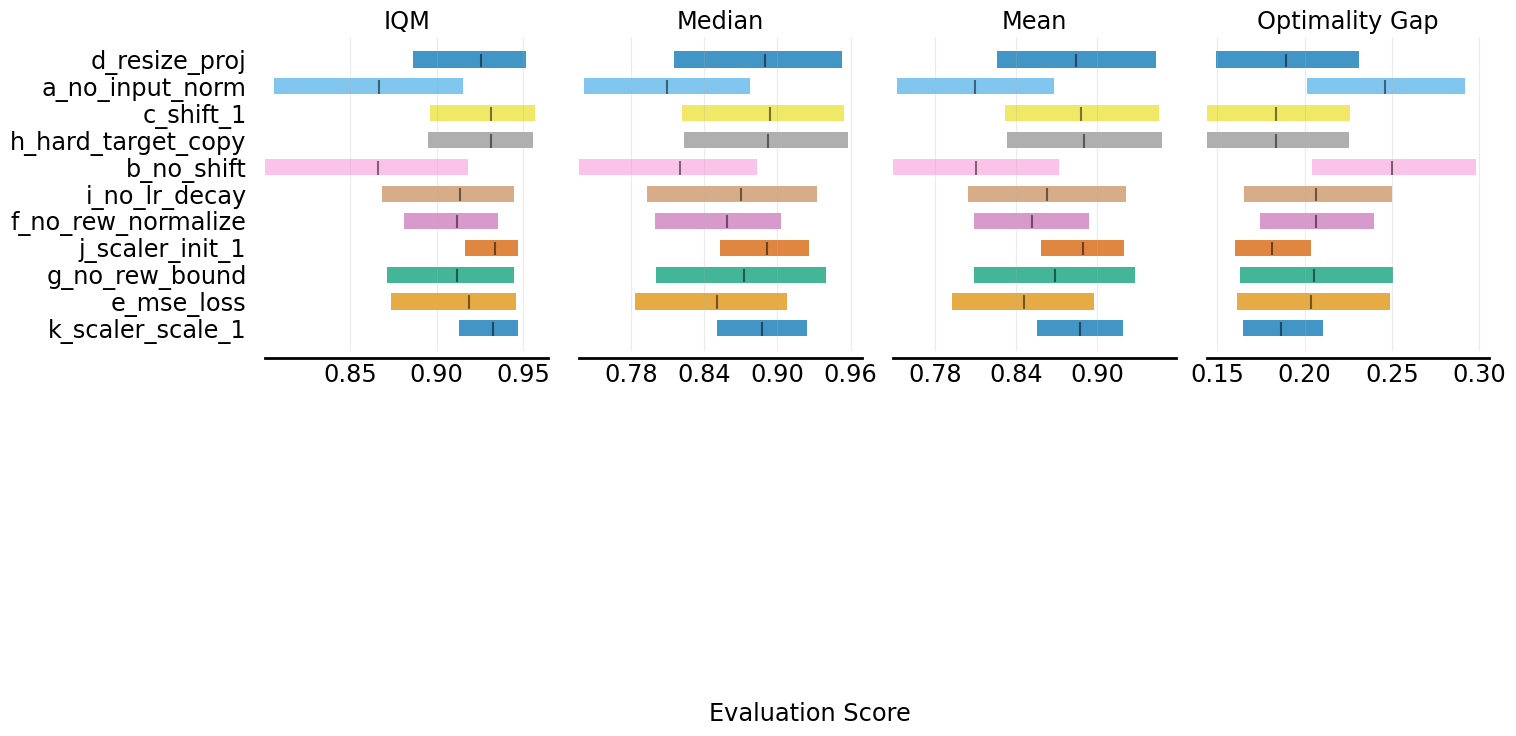

In [51]:
fig, axes = rly_plot_utils.plot_interval_estimates(
    aggregate_scores, aggregate_score_cis,
    metric_names=['IQM', 'Median', 'Mean', 'Optimality Gap'],
    algorithms=cur_exp_names,
    xlabel_y_coordinate=-0.8,
    xlabel='Evaluation Score',
)

In [52]:
for name in aggregate_scores.keys():
    score = aggregate_scores[name][2]
    lower = aggregate_score_cis[name][0][2]
    seeds = metric_matrix_dict[name].shape[1]
    print(seeds, name, score, score-lower)

10 k_scaler_scale_1 0.8874437118630143 0.03202622360206109
3 e_mse_loss 0.8458321662278161 0.05320112808132016
3 g_no_rew_bound 0.8683353308848644 0.059408486073522115
10 j_scaler_init_1 0.8896397890815244 0.03120656095086405
5 f_no_rew_normalize 0.8515658330780793 0.04281496099676518
3 i_no_lr_decay 0.8625416387697111 0.0582383259848227
3 b_no_shift 0.8101432671154303 0.06160168312214975
3 h_hard_target_copy 0.889908464334797 0.05712010788505306
3 c_shift_1 0.887830436897166 0.05599663711085956
3 a_no_input_norm 0.8090277395573439 0.057248587001855644
3 d_resize_proj 0.8838615442993296 0.05789855100632901
